In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, inp_dir, tgt_dir, transform=None):
        self.inp_dir = inp_dir
        self.tgt_dir = tgt_dir
        self.files = sorted(os.listdir(self.inp_dir))
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        inp_path = os.path.join(self.inp_dir, self.files[idx])
        tgt_path = os.path.join(self.tgt_dir, self.files[idx])
        inp_bgr = cv2.imread(inp_path)
        tgt_bgr = cv2.imread(tgt_path)

        inp_rgb = cv2.cvtColor(inp_bgr, cv2.COLOR_BGR2RGB)
        tgt_rgb = cv2.cvtColor(tgt_bgr, cv2.COLOR_BGR2RGB)

        if self.transform:
            inp_tensor = self.transform(Image.fromarray(inp_rgb))
            tgt_tensor = self.transform(Image.fromarray(tgt_rgb))
        else:
            inp_tensor = torch.from_numpy(inp_rgb).permute(2,0,1).float()/255.
            tgt_tensor = torch.from_numpy(tgt_rgb).permute(2,0,1).float()/255.
        return inp_tensor, tgt_tensor

def conv_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

# Stage 1: Denoiser
class Denoiser(nn.Module):
    def __init__(self, channels=3, num_blocks=3):
        super().__init__()
        layers = []
        for _ in range(num_blocks):
            layers.append(nn.Conv2d(channels, channels, 3, padding=1))
            layers.append(nn.BatchNorm2d(channels))
            layers.append(nn.ReLU(inplace=True))
        self.net = nn.Sequential(*layers)
        self.conv_res = nn.Conv2d(channels, channels, 3, padding=1)
    def forward(self, x):
        res = x
        out = self.net(x)
        out = self.conv_res(out)
        return out + res

# Stage 2: BG Removal
class BackgroundRemoval(nn.Module):
    def __init__(self, channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.relu = nn.ReLU(True)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
    def forward(self, x):
        bg = self.conv1(x)
        bg = self.relu(bg)
        bg = self.conv2(bg)
        return x - bg

# Stage 3: Simple MPRNet
class SimpleMPRNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=64):
        super().__init__()
        self.conv1 = conv_block(in_channels, base_channels)
        self.conv2 = conv_block(base_channels, base_channels*2)
        self.pool  = nn.MaxPool2d(2)
        self.bneck = conv_block(base_channels*2, base_channels*4)
        self.up1   = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1  = conv_block(base_channels*4, base_channels*2)
        self.up2   = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2  = conv_block(base_channels*2, base_channels)
        self.conv_last = nn.Conv2d(base_channels, out_channels, 3, padding=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        xb = self.bneck(self.pool(x2))
        x_up1 = self.up1(xb)
        x_d1  = self.dec1(x_up1)
        if x_d1.shape == x2.shape:
            x_d1 = x_d1 + x2
        x_up2 = self.up2(x_d1)
        x_d2  = self.dec2(x_up2)
        if x_d2.shape == x1.shape:
            x_d2 = x_d2 + x1
        out   = self.conv_last(x_d2)
        return out

class StarEnhancementNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage1 = Denoiser(3,3)
        self.stage2 = BackgroundRemoval(3)
        self.stage3 = SimpleMPRNet(3,3,64)
    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        return x
    
def brightness_loss(output, target):
    out_mean = torch.mean(output, dim=[1,2,3])
    tgt_mean = torch.mean(target, dim=[1,2,3])
    return torch.mean(torch.abs(out_mean - tgt_mean))

def color_consistency_loss(output, target):
    out_mean = output.mean(dim=[2,3])  # [B,C]
    tgt_mean = target.mean(dim=[2,3])  # [B,C]
    return torch.mean(torch.abs(out_mean - tgt_mean))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
l1_criterion = nn.L1Loss()

brightness_weight = 0.05
color_weight = 0.05

def compute_loss_with_color_brightness(output, target):
    # L1 + brightness + color
    l1 = l1_criterion(output, target)
    b_loss = brightness_loss(output, target)
    c_loss = color_consistency_loss(output, target)
    return l1 + brightness_weight*b_loss + color_weight*c_loss

def show_val_results(model, loader, stage_name="StageX", n_examples=3):
    model.eval()
    count=0
    with torch.no_grad():
        for inp, tgt in loader:
            inp=inp.to(device)
            tgt=tgt.to(device)
            out=model(inp)
            out=torch.clamp(out,0,1)

            inp_np = inp[0].permute(1,2,0).cpu().numpy()
            out_np = out[0].permute(1,2,0).cpu().numpy()
            tgt_np = tgt[0].permute(1,2,0).cpu().numpy()
            # calculate psnr
            mse = F.mse_loss(out, tgt)
            psnr = 10 * torch.log10(1 / mse)

            fig, axes=plt.subplots(1,3, figsize=(12,4))
            axes[0].imshow(inp_np)
            axes[0].set_title("Input")
            axes[0].axis("off")
            axes[1].imshow(out_np)
            axes[1].set_title("Output")
            axes[1].axis("off")
            axes[2].imshow(tgt_np)
            axes[2].set_title("GroundTruth")
            axes[2].axis("off")
            fig.suptitle(f"{stage_name} Val Example #{count} PSNR={psnr:.4f}")
            save_name=f"{stage_name}_val_{count}.png"
            plt.savefig(save_name)
            plt.show()

            count+=1
            if count>=n_examples:
                break

# Stage 1
def train_stage1(epochs=10):
    print("Train Stage1 (Denoiser)...")
    train_inp="./stage1_denoising/train/input"
    train_tgt="./stage1_denoising/train/target"
    val_inp="./stage1_denoising/val/input"
    val_tgt="./stage1_denoising/val/target"

    transform=transforms.ToTensor()
    train_ds=PairedDataset(train_inp, train_tgt, transform)
    val_ds=PairedDataset(val_inp, val_tgt, transform)

    train_loader=DataLoader(train_ds,batch_size=4,shuffle=True)
    val_loader=DataLoader(val_ds,batch_size=4,shuffle=False)

    model=Denoiser().to(device)
    optimizer=optim.Adam(model.parameters(), lr=1e-4)

    train_loss_list=[]
    val_loss_list=[]

    for epoch in range(epochs):
        model.train()
        running=0
        for inp, tgt in tqdm(train_loader,desc=f"Stage1 Epoch[{epoch+1}/{epochs}]",leave=False):
            inp, tgt=inp.to(device), tgt.to(device)
            out=model(inp)
            loss=compute_loss_with_color_brightness(out, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running+=loss.item()

        avg_tr=running/len(train_loader)
        train_loss_list.append(avg_tr)

        # Validation
        model.eval()
        val_running=0
        with torch.no_grad():
            for inp, tgt in val_loader:
                inp, tgt=inp.to(device), tgt.to(device)
                out=model(inp)
                vloss=compute_loss_with_color_brightness(out, tgt)
                val_running+=vloss.item()
        avg_val=val_running/len(val_loader)
        val_loss_list.append(avg_val)
        if epoch%50==0:
            # calculate psnr
            mse = F.mse_loss(out, tgt)
            psnr = 10 * torch.log10(1 / mse)
            print(f"[Stage1] Epoch {epoch+1}/{epochs}: TrainLoss={avg_tr:.4f}, ValLoss={avg_val:.4f}, PSNR={psnr:.4f}")

    # Save
    torch.save(model.state_dict(),"stage1_denoiser.pth")
    plt.figure()
    plt.plot(train_loss_list,label="TrainLoss")
    plt.plot(val_loss_list,label="ValLoss")
    plt.legend()
    plt.title("Stage1 Denoiser Loss (+Color,Brightness)")
    plt.savefig("stage1_loss_plot.png")

    show_val_results(model,val_loader,stage_name="Stage1")
    return model

# Stage 2
def train_stage2(epochs=10):
    print("Train Stage2 (BG Removal)...")
    train_inp="./stage2_bg_removed/train/input"
    train_tgt="./stage2_bg_removed/train/target"
    val_inp="./stage2_bg_removed/val/input"
    val_tgt="./stage2_bg_removed/val/target"

    transform=transforms.ToTensor()
    train_ds=PairedDataset(train_inp, train_tgt, transform)
    val_ds=PairedDataset(val_inp, val_tgt, transform)
    train_loader=DataLoader(train_ds,batch_size=4,shuffle=True)
    val_loader=DataLoader(val_ds,batch_size=4,shuffle=False)

    model=BackgroundRemoval().to(device)
    optimizer=optim.Adam(model.parameters(),lr=1e-4)

    trl=[]
    vl=[]
    for epoch in range(epochs):
        model.train()
        running=0
        for inp,tgt in tqdm(train_loader,desc=f"Stage2 Epoch[{epoch+1}/{epochs}]",leave=False):
            inp,tgt=inp.to(device),tgt.to(device)
            out=model(inp)
            loss=compute_loss_with_color_brightness(out, tgt)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running+=loss.item()
        avg_tr=running/len(train_loader)
        trl.append(avg_tr)

        # val
        model.eval()
        val_r=0
        with torch.no_grad():
            for inp,tgt in val_loader:
                inp,tgt=inp.to(device),tgt.to(device)
                out=model(inp)
                vloss=compute_loss_with_color_brightness(out, tgt)
                val_r+=vloss.item()
        avg_v=val_r/len(val_loader)
        vl.append(avg_v)
        if epoch%50==0:
            mse = F.mse_loss(out, tgt)
            psnr = 10 * torch.log10(1 / mse)
            print(f"[Stage2] Epoch {epoch+1}/{epochs}: TrainLoss={avg_tr:.4f}, ValLoss={avg_v:.4f}, PSNR={psnr:.4f}")
    
    torch.save(model.state_dict(), "stage2_bgremoval.pth")
    plt.figure()
    plt.plot(trl,label="TrainLoss")
    plt.plot(vl,label="ValLoss")
    plt.title("Stage2 BGRemoval Loss (+Color,Brightness)")
    plt.legend()
    plt.savefig("stage2_loss_plot.png")

    show_val_results(model,val_loader,stage_name="Stage2")
    return model

# Stage 3
def train_stage3(epochs=10):
    print("Train Stage3 (Deblurring) ...")
    train_inp="./stage3_final/train/input"
    train_tgt="./stage3_final/train/target"
    val_inp="./stage3_final/val/input"
    val_tgt="./stage3_final/val/target"

    transform=transforms.ToTensor()
    train_ds=PairedDataset(train_inp, train_tgt, transform)
    val_ds=PairedDataset(val_inp, val_tgt, transform)
    train_loader=DataLoader(train_ds,batch_size=4,shuffle=True)
    val_loader=DataLoader(val_ds,batch_size=4,shuffle=False)

    model=SimpleMPRNet().to(device)
    if os.path.exists("stage3_deblurrer.pth"):
        model.load_state_dict(torch.load("stage3_deblurrer.pth"))
        print("Loaded pretrained model for Stage3")
    optimizer=optim.Adam(model.parameters(),lr=1e-4)

    trl=[]
    vl=[]
    for epoch in range(epochs):
        model.train()
        running=0
        for inp,tgt in tqdm(train_loader,desc=f"Deblur Epoch[{epoch+1}/{epochs}]",leave=False):
            inp,tgt=inp.to(device),tgt.to(device)
            out=model(inp)
            loss=compute_loss_with_color_brightness(out, tgt)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running+=loss.item()
        avg_tr=running/len(train_loader)
        trl.append(avg_tr)

        model.eval()
        val_r=0
        with torch.no_grad():
            for inp,tgt in val_loader:
                inp,tgt=inp.to(device),tgt.to(device)
                out=model(inp)
                vloss=compute_loss_with_color_brightness(out, tgt)
                val_r+=vloss.item()
        avg_v=val_r/len(val_loader)
        vl.append(avg_v)
        if epoch%50==0:
            mse = F.mse_loss(out, tgt)
            psnr = 10 * torch.log10(1 / mse)
            print(f"[Stage3] Epoch {epoch+1}/{epochs}: TrainLoss={avg_tr:.4f}, ValLoss={avg_v:.4f}, PSNR={psnr:.4f}")

    torch.save(model.state_dict(),"stage3_deblurrer_2.pth")
    plt.figure()
    plt.plot(trl,label="TrainLoss")
    plt.plot(vl,label="ValLoss")
    plt.title("Stage3 Deblurring Loss (+Color,Brightness)")
    plt.legend()
    plt.savefig("stage3_loss_plot.png")

    show_val_results(model,val_loader,stage_name="Stage3")
    return model

def fine_tune_entire_pipeline(epochs=5):
    print("Fine-tuning entire pipeline (StarEnhancementNet) ...")
    net=StarEnhancementNet().to(device)
    net.stage1.load_state_dict(torch.load("stage1_denoiser.pth"))
    net.stage2.load_state_dict(torch.load("stage2_bgremoval.pth"))
    net.stage3.load_state_dict(torch.load("stage3_deblurrer_2.pth"))

    final_inp_dir="./stage4_allinone-3/train/input"
    final_tgt_dir="./stage3_final-3/train/target"
    transform=transforms.ToTensor()
    train_ds=PairedDataset(final_inp_dir, final_tgt_dir, transform)
    train_loader=DataLoader(train_ds,batch_size=4,shuffle=True)

    optimizer=optim.Adam(net.parameters(), lr=1e-5)
    fine_losses=[]
    for epoch in range(epochs):
        net.train()
        running=0
        for inp,tgt in tqdm(train_loader,desc=f"FineTune Epoch[{epoch+1}/{epochs}]",leave=False):
            inp,tgt=inp.to(device),tgt.to(device)
            out=net(inp)
            loss=compute_loss_with_color_brightness(out,tgt)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running+=loss.item()
        avgL=running/len(train_loader)
        fine_losses.append(avgL)
        if epoch%50==0:
            mse = F.mse_loss(out, tgt)
            psnr = 10 * torch.log10(1 / mse)
            print(f"FineTune Epoch {epoch+1}: Loss={avgL:.4f}, PSNR={psnr:.4f}")
    
    torch.save(net.state_dict(),"final_pipeline_finetuned_w_allinone_e500.pth")
    plt.figure()
    plt.plot(fine_losses,label="FineTune Loss")
    plt.title("Fine-tuning End-to-End Loss (+Color,Brightness)")
    plt.legend()
    plt.savefig("fine_tune_loss_w_allinone.png")
    print("Fine-tuning complete.")

    val_inp="./stage4_allinone-3/val/input"
    val_tgt="./stage4_final-3/val/target"
    val_ds=PairedDataset(val_inp,val_tgt,transform)
    val_loader=DataLoader(val_ds,batch_size=4,shuffle=False)
    show_val_results(net,val_loader,stage_name="FinalPipeline",n_examples=3)

if __name__=="__main__":
    stage1_model = train_stage1(epochs=800)
    stage2_model = train_stage2(epochs=800)
    stage3_model = train_stage3(epochs=1000)
    fine_tune_entire_pipeline(epochs=500)
    print("All training done. Check your saved plots & weights!")


#### Testing

Loaded pipeline from final_pipeline_finetuned.pth
Image resolution: 4640 x 6960


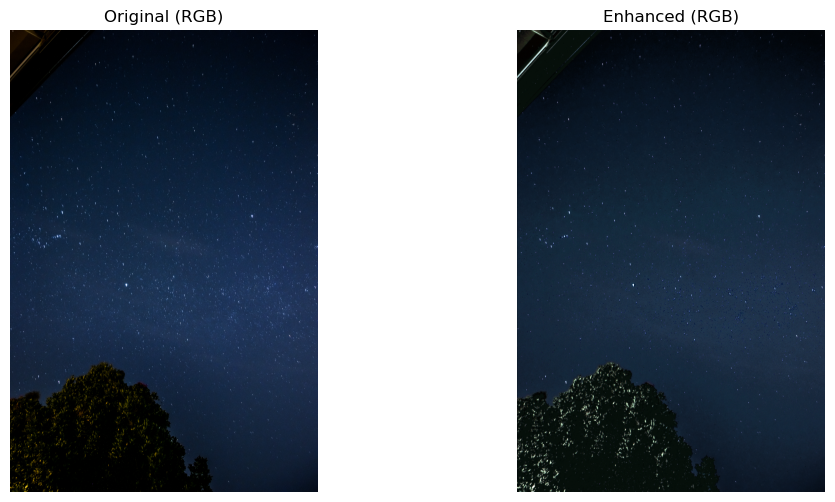

Saved enhanced image => multi-stage-allinone-results/enhanced_fine_2_2.jpg


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import argparse

def conv_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

class Denoiser(nn.Module):
    def __init__(self, channels=3, num_blocks=3):
        super().__init__()
        layers = []
        for _ in range(num_blocks):
            layers.append(nn.Conv2d(channels, channels, 3, padding=1))
            layers.append(nn.BatchNorm2d(channels))
            layers.append(nn.ReLU(inplace=True))
        self.net = nn.Sequential(*layers)
        self.conv_res = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        res = x
        out = self.net(x)
        out = self.conv_res(out)
        return out + res

class BackgroundRemoval(nn.Module):
    def __init__(self, channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.relu  = nn.ReLU(True)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        bg = self.conv1(x)
        bg = self.relu(bg)
        bg = self.conv2(bg)
        return x - bg

class SimpleMPRNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=64):
        super().__init__()
        self.conv1 = conv_block(in_channels, base_channels)
        self.conv2 = conv_block(base_channels, base_channels*2)
        self.pool  = nn.MaxPool2d(2)
        self.bneck = conv_block(base_channels*2, base_channels*4)
        self.up1   = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1  = conv_block(base_channels*4, base_channels*2)
        self.up2   = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2  = conv_block(base_channels*2, base_channels)
        self.conv_last = nn.Conv2d(base_channels, out_channels, 3, padding=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        xb = self.bneck(self.pool(x2))
        x_up1 = self.up1(xb)
        x_d1  = self.dec1(x_up1)
        if x_d1.shape==x2.shape:
            x_d1 = x_d1 + x2
        x_up2 = self.up2(x_d1)
        x_d2  = self.dec2(x_up2)
        if x_d2.shape==x1.shape:
            x_d2 = x_d2 + x1
        out   = self.conv_last(x_d2)
        return out

class StarEnhancementNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage1 = Denoiser(channels=3, num_blocks=3)
        self.stage2 = BackgroundRemoval(channels=3)
        self.stage3 = SimpleMPRNet(in_channels=3, out_channels=3, base_channels=64)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        return x

def hann_window_2d(tile_size):
    hann_1d = 0.5 - 0.5 * np.cos(2.0 * np.pi * np.linspace(0,1,tile_size))
    window_2d = np.outer(hann_1d, hann_1d).astype(np.float32)
    return window_2d

def tile_inference(model, input_tensor, tile_size=256, tile_overlap=32, device='cuda'):
    b, c, H, W = input_tensor.shape
    stride = tile_size - tile_overlap

    hann_2d = hann_window_2d(tile_size)
    hann_mask = torch.from_numpy(hann_2d).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,ts,ts]

    output = torch.zeros_like(input_tensor, device=device)
    weight = torch.zeros_like(input_tensor, device=device)

    h_idxs = list(range(0, max(0, H - tile_size), stride)) + [max(0, H - tile_size)]
    w_idxs = list(range(0, max(0, W - tile_size), stride)) + [max(0, W - tile_size)]

    for hy in h_idxs:
        for wx in w_idxs:
            patch = input_tensor[:, :, hy:hy+tile_size, wx:wx+tile_size]
            ph, pw = patch.shape[2], patch.shape[3]
            if ph<tile_size or pw<tile_size:
                pad_h = tile_size - ph
                pad_w = tile_size - pw
                patch = F.pad(patch, (0,pad_w,0,pad_h), mode='reflect')

            with torch.no_grad():
                out_patch = model(patch)

            out_patch = out_patch[:, :, :ph, :pw]

            output[:, :, hy:hy+ph, wx:wx+pw] += out_patch * hann_mask[..., :ph, :pw]
            weight[:, :, hy:hy+ph, wx:wx+pw] += hann_mask[..., :ph, :pw]

    output = output / torch.clamp(weight, min=1e-8)
    return output

def test_single_image(image_path, checkpoint_path, tile_size=256, tile_overlap=32):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = StarEnhancementNet().to(device)
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"Loaded pipeline from {checkpoint_path}")
    else:
        raise ValueError(f"Checkpoint not found at {checkpoint_path}")
    model.eval()

    orig_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if orig_bgr is None:
        raise ValueError(f"Cannot read image at {image_path}")
    H, W = orig_bgr.shape[:2]
    print(f"Image resolution: {W} x {H}")

    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

    inp_tensor = torch.from_numpy(orig_rgb).float()/255.0
    inp_tensor = inp_tensor.permute(2,0,1).unsqueeze(0).to(device)

    _,_,H2,W2 = inp_tensor.shape
    pad_h = (tile_size - (H2 % tile_size)) % tile_size
    pad_w = (tile_size - (W2 % tile_size)) % tile_size
    if pad_h!=0 or pad_w!=0:
        inp_tensor = F.pad(inp_tensor, (0,pad_w,0,pad_h), mode='reflect')

    with torch.no_grad():
        out_tensor = tile_inference(model, inp_tensor, tile_size, tile_overlap, device=device)

    out_tensor = out_tensor[:,:,:H2,:W2]

    out_tensor = torch.clamp(out_tensor, 0,1)
    out_np = out_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    out_np_uint8 = (out_np*255).astype(np.uint8)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(orig_rgb)
    plt.title("Original (RGB)")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(out_np_uint8)
    plt.title("Enhanced (RGB)")
    plt.axis("off")
    plt.show()

    out_bgr = cv2.cvtColor(out_np_uint8, cv2.COLOR_RGB2BGR)
    out_dir = "multi-stage-allinone-results"
    save_name = os.path.join(out_dir, f"enhanced_fine_2_{os.path.basename(image_path)}")
    cv2.imwrite(save_name, out_bgr)
    print(f"Saved enhanced image => {save_name}")

if __name__=="__main__":
    image_path = "2.jpg"
    checkpoint_path = "final_pipeline_finetuned.pth"

    test_single_image(image_path, checkpoint_path, tile_size=512, tile_overlap=32)